# Load Dictionaries

In [10]:
import torch
from transformer_lens import HookedTransformer
import numpy as np 
from torch import nn

#Change these settings to load the correct autoencoder
setting = "residual"
model_name = "EleutherAI/pythia-70m-deduped"
# model_name = "EleutherAI/pythia-160m-deduped"
l1_index = 0
dict_index = 2
layers = [0,1,2,3,4,5]
autoencoders = []
dictionaries = []
dictionaries_2 = []

device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")
model = HookedTransformer.from_pretrained(model_name, device=device)
l1_index = [8, 9, 9, 9, 10, 11]
for layer in layers:
    # Load the pickle file
    # filename = f"pythia160m/output_hoagy_dense_sweep_tied_residual_l{layer}_r4/_29/learned_dicts.pt"
    
    
    filename = f"/mnt/ssd-cluster/bigrun0308/tied_residual_l{layer}_r8/_9/learned_dicts.pt"
    all_autoencoders = torch.load(filename)
    # Index for l1 value, usually only 1 value is available
    autoencoder, hyperparams = all_autoencoders[l1_index[layer]]
    dictionary = autoencoder.get_learned_dict()
    dictionaries.append(dictionary)
    autoencoders.append(autoencoder)
    

    autoencoder2, hyperparams2 = all_autoencoders[l1_index[layer]+1]
    dictionary2 = autoencoder2.get_learned_dict()
    dictionaries_2.append(dictionary2)

Using pad_token, but it is not set yet.


Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer


In [11]:
all_autoencoders[4], all_autoencoders[8], all_autoencoders[12], all_autoencoders[14]

((<autoencoders.learned_dict.TiedSAE at 0x7f3d704234c0>,
  {'dict_size': 4096, 'l1_alpha': 0.0003414548991713673}),
 (<autoencoders.learned_dict.TiedSAE at 0x7f3d70422980>,
  {'dict_size': 4096, 'l1_alpha': 0.001165914349257946}),
 (<autoencoders.learned_dict.TiedSAE at 0x7f3e0c6e71c0>,
  {'dict_size': 4096, 'l1_alpha': 0.003981071524322033}),
 (<autoencoders.learned_dict.TiedSAE at 0x7f3d705c0550>,
  {'dict_size': 4096, 'l1_alpha': 0.007356422487646341}))

# MCS
Across Dictionaries

('# of features above 0.9:', 57)
('# of features above 0.9:', 43)
('# of features above 0.9:', 12)
('# of features above 0.9:', 20)
('# of features above 0.9:', 0)


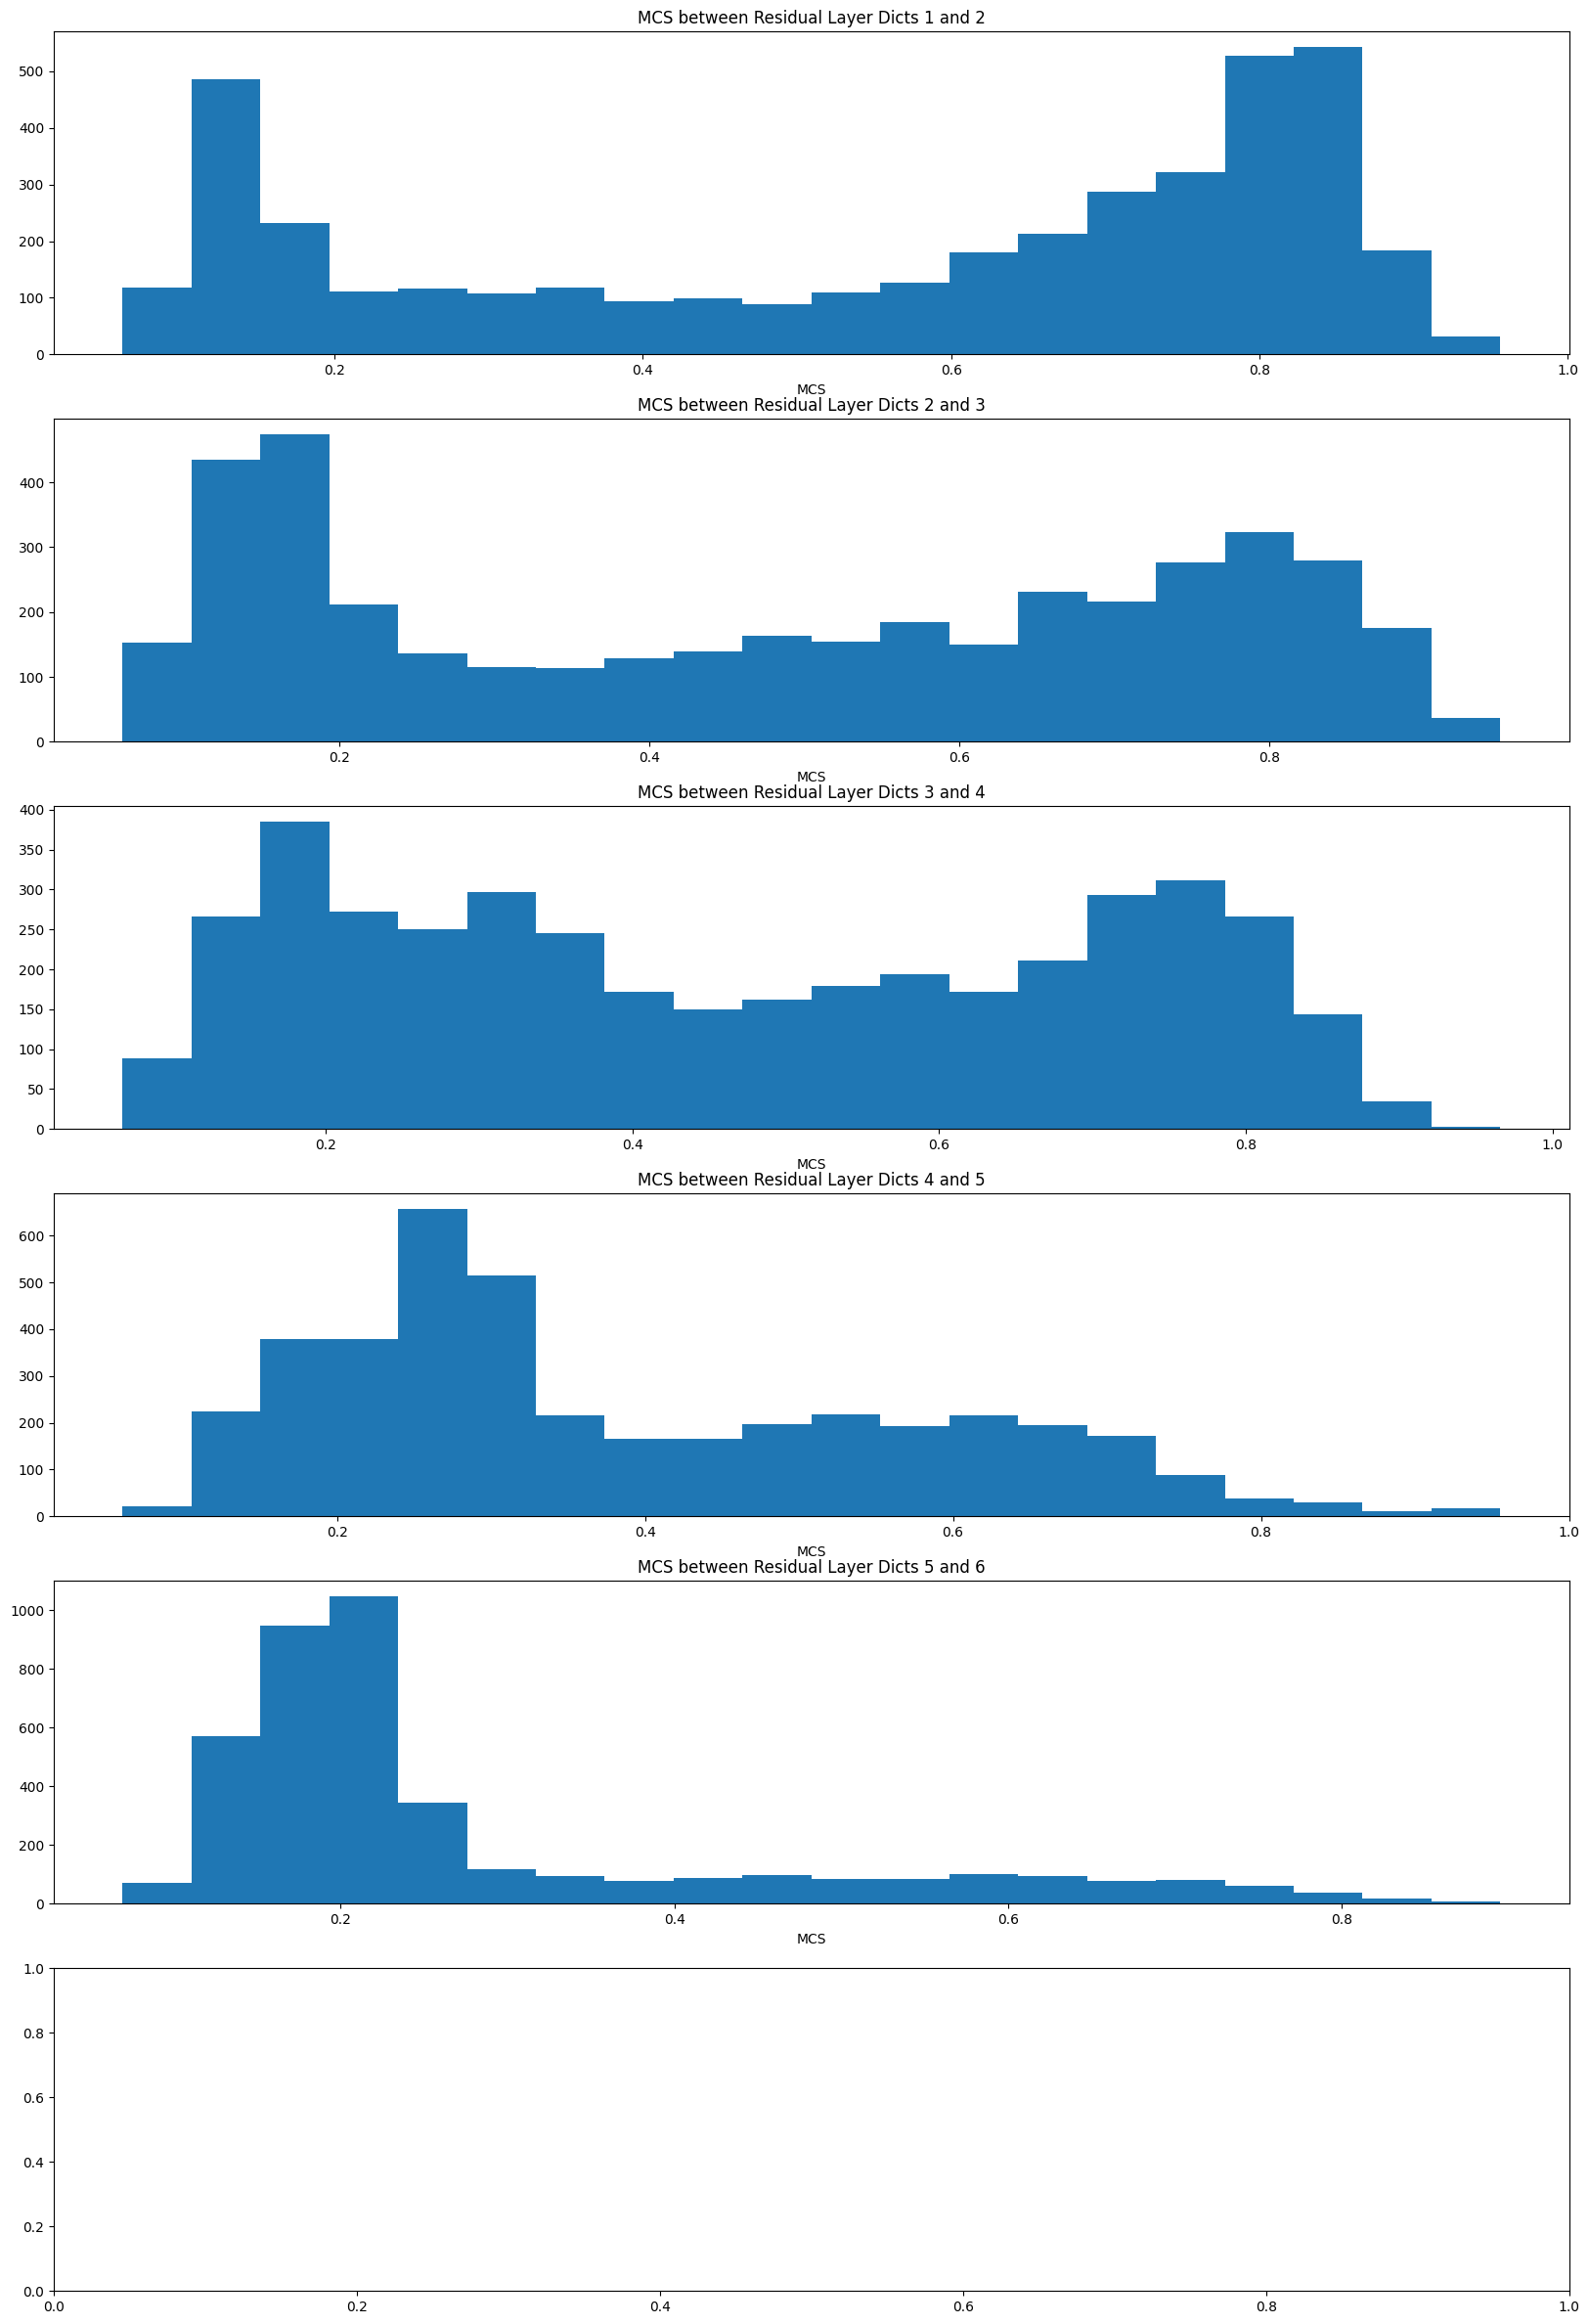

In [12]:
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
# Loop through the dictionaries in dictionaries
fig, axs = plt.subplots(6, figsize=(20, 30))

for i in range(len(dictionaries)-1):
    smaller_dict, larger_dict = dictionaries[i], dictionaries[i+1]

    #Dictionary Comparison
    smaller_dict_features, _ = smaller_dict.shape
    larger_dict_features, _ = larger_dict.shape
    larger_dict = larger_dict.to(device)
    # Hungary algorithm
    # Calculate all cosine similarities and store in a 2D array
    cos_sims = np.zeros((smaller_dict_features, larger_dict_features))
    for idx, vector in enumerate(smaller_dict):
        cos_sims[idx] = torch.nn.functional.cosine_similarity(vector.to(device), larger_dict, dim=1).cpu().numpy()
    # Convert to a minimization problem
    cos_sims = 1 - cos_sims
    # Use the Hungarian algorithm to solve the assignment problem
    row_ind, col_ind = linear_sum_assignment(cos_sims)
    # Retrieve the max cosine similarities and corresponding indices
    max_cosine_similarities = 1 - cos_sims[row_ind, col_ind]

    # Get the indices of the max cosine similarities in descending order
    max_indices = np.argsort(max_cosine_similarities)[::-1]
    max_cosine_similarities[max_indices][:20]
    print(("# of features above 0.9:", (max_cosine_similarities > .9).sum()))

    # Plot histogram of max_cosine_similarities
    axs[i].hist(max_cosine_similarities, bins=20)
    axs[i].set_title(f"MCS between Residual Layer Dicts {i+1} and {i+2}")
    axs[i].set_xlabel("MCS")
plt.show()

Across dictionaries of same Layer for MCS

('# of features above 0.9:', 2419)
('# of features above 0.9:', 2231)
('# of features above 0.9:', 1508)
('# of features above 0.9:', 1312)
('# of features above 0.9:', 1139)
('# of features above 0.9:', 352)


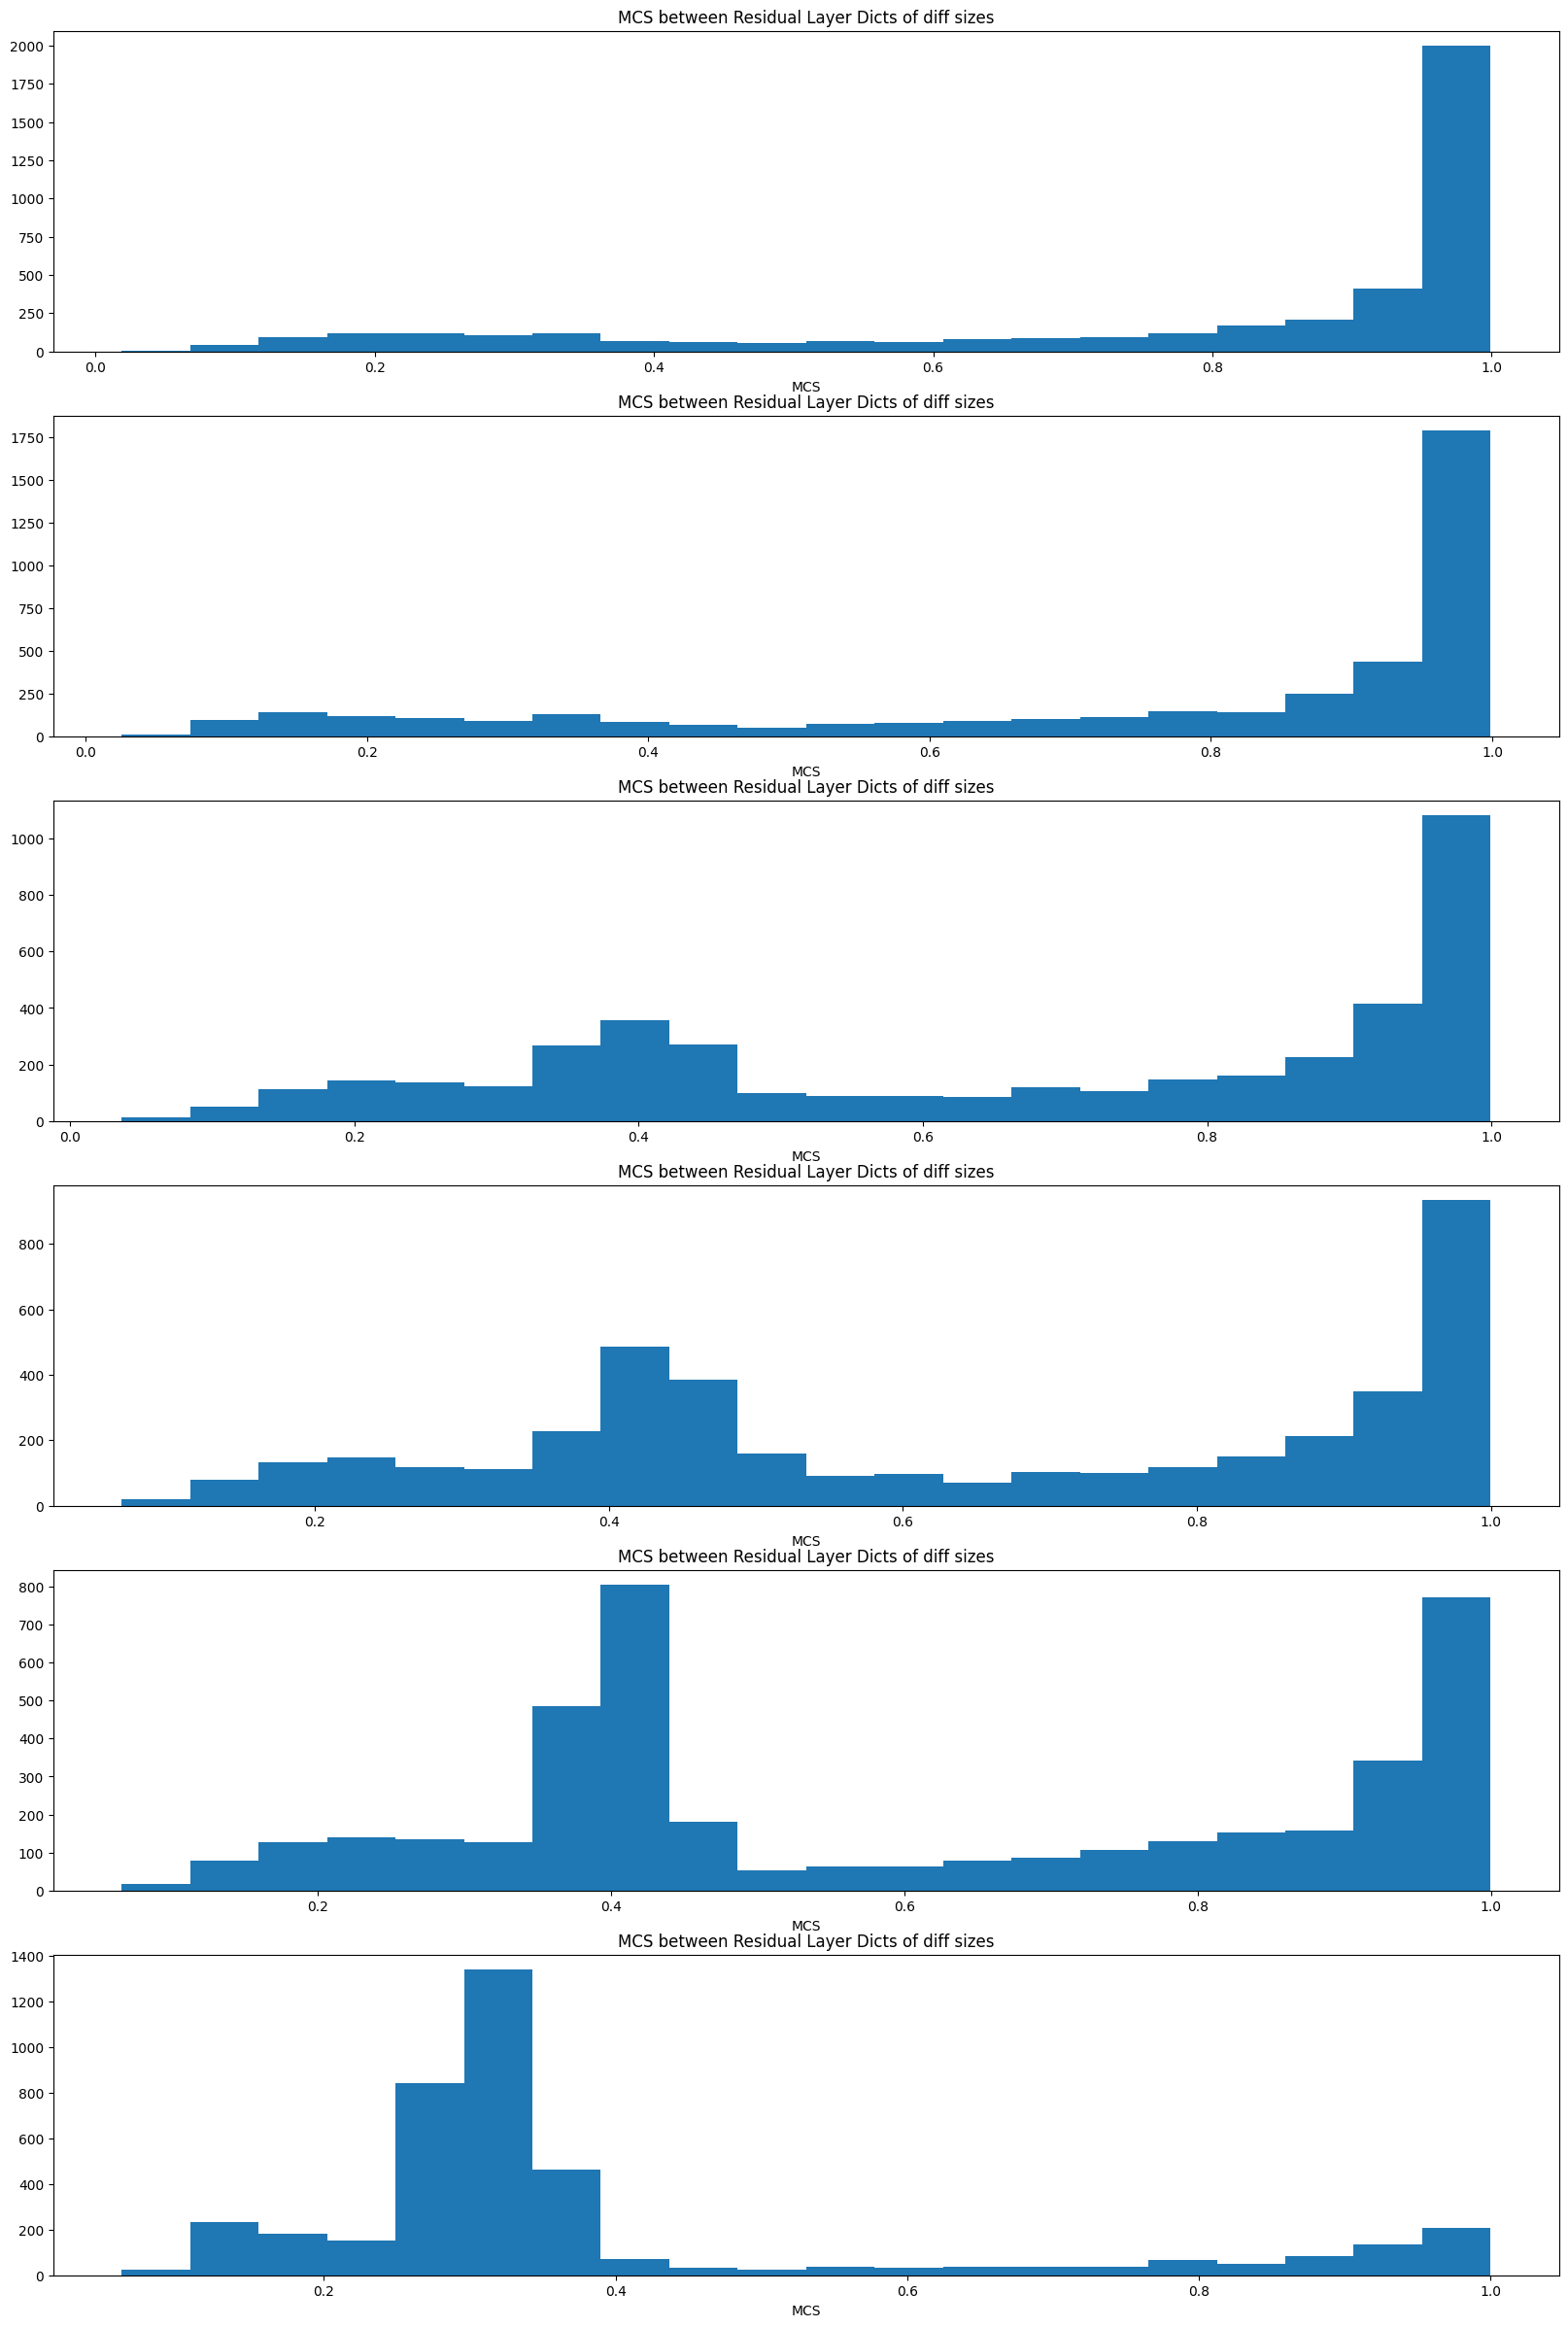

In [13]:
from scipy.optimize import linear_sum_assignment
import matplotlib.pyplot as plt
# Loop through the dictionaries in dictionaries
fig, axs = plt.subplots(6, figsize=(20, 30))
max_indices = []
for i in range(len(dictionaries)):
    smaller_dict, larger_dict = dictionaries[i], dictionaries_2[i]

    #Dictionary Comparison
    smaller_dict_features, _ = smaller_dict.shape
    larger_dict_features, _ = larger_dict.shape
    larger_dict = larger_dict.to(device)
    # Hungary algorithm
    # Calculate all cosine similarities and store in a 2D array
    cos_sims = np.zeros((smaller_dict_features, larger_dict_features))
    for idx, vector in enumerate(smaller_dict):
        cos_sims[idx] = torch.nn.functional.cosine_similarity(vector.to(device), larger_dict, dim=1).cpu().numpy()
    # Convert to a minimization problem
    cos_sims = 1 - cos_sims
    # Use the Hungarian algorithm to solve the assignment problem
    row_ind, col_ind = linear_sum_assignment(cos_sims)
    # Retrieve the max cosine similarities and corresponding indices
    max_cosine_similarities = 1 - cos_sims[row_ind, col_ind]

    # Get the indices of the max cosine similarities in descending order
    select_max_indices = np.argsort(max_cosine_similarities)[::-1]
    max_indices.append(select_max_indices)
    print(("# of features above 0.9:", (max_cosine_similarities > .9).sum()))

    # Plot histogram of max_cosine_similarities
    axs[i].hist(max_cosine_similarities, bins=20)
    axs[i].set_title(f"MCS between Residual Layer Dicts of diff sizes")
    axs[i].set_xlabel("MCS")
plt.show()

# Model activations & Dictionary Activations

In [14]:
# Downnload dataset
from datasets import Dataset, load_dataset
dataset_name = "NeelNanda/pile-10k"
token_amount= 30
dataset = load_dataset(dataset_name, split="train[:4000]").map(
    lambda x: model.tokenizer(x['text']),
    batched=True,
).filter(
    lambda x: len(x['input_ids']) > token_amount
).map(
    lambda x: {'input_ids': x['input_ids'][:token_amount]}
)

Found cached dataset parquet (/home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached processed dataset at /home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-0dfd8ce12bb4e927.arrow
Loading cached processed dataset at /home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-c6873be80f27471f.arrow
Loading cached processed dataset at /home/mchorse/.cache/huggingface/datasets/NeelNanda___parquet/NeelNanda--pile-10k-72f566e9f7c464ab/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-d439d550b657552b.arrow


In [15]:
# Now we can use the model to get the activations
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from einops import rearrange
# neurons = model.W_in.shape[-1]
neurons = model.cfg.d_model
datapoints = dataset.num_rows
batch_size = 32
all_dict_activations = []
all_neuron_activations = []

with torch.no_grad(), dataset.formatted_as("pt"):
    dl = DataLoader(dataset["input_ids"], batch_size=batch_size)
    for layer in range(len(layers)):
        neuron_activations = torch.zeros((datapoints*token_amount, neurons))
        dictionary_activations = torch.zeros((datapoints*token_amount, smaller_dict_features))
        for i, batch in enumerate(tqdm(dl)):
            current_autoencoder = autoencoders[layer]
            current_autoencoder.to_device(device)
            
            _, cache = model.run_with_cache(batch.to(device))
            cache_name = f"blocks.{layers[layer]}.hook_resid_post"
            
            batched_neuron_activations = rearrange(cache[cache_name], "b s n -> (b s) n" )
            neuron_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_neuron_activations.cpu()

            batched_dictionary_activations = current_autoencoder.encode(batched_neuron_activations)
            dictionary_activations[i*batch_size*token_amount:(i+1)*batch_size*token_amount,:] = batched_dictionary_activations.cpu()

        all_dict_activations.append(dictionary_activations)
        all_neuron_activations.append(neuron_activations)

100%|██████████| 124/124 [00:03<00:00, 34.81it/s]


# Feature Activation Analysis

## Useful Functions

In [16]:
from circuitsvis.activations import text_neuron_activations
# Get the activations for the best dict features
def get_feature_datapoints(feature_index, dictionary_activations, dataset, k=10, setting="max"):
    best_feature_activations = dictionary_activations[:, feature_index]
    # Sort the features by activation, get the indices
    if setting=="max":
        found_indices = torch.argsort(best_feature_activations, descending=True)[:k]
    elif setting=="uniform":
        # min_value = torch.min(best_feature_activations)
        min_value = torch.min(best_feature_activations)
        max_value = torch.max(best_feature_activations)

        # Define the number of bins
        num_bins = k

        # Calculate the bin boundaries as linear interpolation between min and max
        bin_boundaries = torch.linspace(min_value, max_value, num_bins + 1)

        # Assign each activation to its respective bin
        bins = torch.bucketize(best_feature_activations, bin_boundaries)

        # Initialize a list to store the sampled indices
        sampled_indices = []

        # Sample from each bin
        for bin_idx in torch.unique(bins):
            if(bin_idx==0): # Skip the first one. This is below the median
                continue
            # Get the indices corresponding to the current bin
            bin_indices = torch.nonzero(bins == bin_idx, as_tuple=False).squeeze(dim=1)
            
            # Randomly sample from the current bin
            sampled_indices.extend(np.random.choice(bin_indices, size=1, replace=False))

        # Convert the sampled indices to a PyTorch tensor & reverse order
        found_indices = torch.tensor(sampled_indices).long().flip(dims=[0])
    else: # random
        # get nonzero indices
        nonzero_indices = torch.nonzero(best_feature_activations)[:, 0]
        # shuffle
        shuffled_indices = nonzero_indices[torch.randperm(nonzero_indices.shape[0])]
        found_indices = shuffled_indices[:k]
    datapoint_indices =[np.unravel_index(i, (datapoints, token_amount)) for i in found_indices]
    text_list = []
    full_text = []
    token_list = []
    full_token_list = []
    for md, s_ind in datapoint_indices:
        md = int(md)
        s_ind = int(s_ind)
        full_tok = torch.tensor(dataset[md]["input_ids"])
        full_text.append(model.tokenizer.decode(full_tok))
        tok = dataset[md]["input_ids"][:s_ind+1]
        text = model.tokenizer.decode(tok)
        text_list.append(text)
        token_list.append(tok)
        full_token_list.append(full_tok)
    return text_list, full_text, token_list, full_token_list

def get_neuron_activation(token, feature, model, autoencoder, layer, setting="dictionary_basis"):
    with torch.no_grad():
        _, cache = model.run_with_cache(token.to(model.cfg.device))
        cache_name = f"blocks.{layer}.hook_resid_post"
        neuron_act_batch = cache[cache_name]
        if setting=="dictionary_basis":
            act = autoencoder.encode(neuron_act_batch.squeeze(0))
            return act[:, feature].tolist()
        else: # neuron/residual basis
            return neuron_act_batch[0, :, feature].tolist()

def ablate_text(text, feature, model, autoencoder, layer,  setting="plot"):
    if isinstance(text, str):
        text = [text]
    display_text_list = []
    activation_list = []
    for t in text:
        # Convert text into tokens
        if isinstance(t, str): # If the text is a list of tokens
            split_text = model.to_str_tokens(t, prepend_bos=False)
            tokens = model.to_tokens(t, prepend_bos=False)
        else: # t equals tokens
            tokens = t
            split_text = model.to_str_tokens(t, prepend_bos=False)
        seq_size = tokens.shape[1]
        if(seq_size == 1): # If the text is a single token, we can't ablate it
            continue
        original = get_neuron_activation(tokens, feature, model, autoencoder, layer)[-1]
        changed_activations = torch.zeros(seq_size, device=device).cpu()
        for i in range(seq_size):
            # Remove the i'th token from the input
            ablated_tokens = torch.cat((tokens[:,:i], tokens[:,i+1:]), dim=1)
            changed_activations[i] += get_neuron_activation(ablated_tokens, feature, model, autoencoder, layer)[-1]
        changed_activations -= original
        display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        activation_list += changed_activations.tolist() + [0.0]
    activation_list = torch.tensor(activation_list).reshape(-1,1,1)
    if setting == "plot":
        return text_neuron_activations(tokens=display_text_list, activations=activation_list)
    else:
        return display_text_list, activation_list
        
def visualize_text(text, feature, model,autoencoder, layer, setting="dictionary_basis", max_activation = None):
    if isinstance(text, str):
        text = [text]
    if isinstance(feature, int):
        feature = [feature]
    display_text_list = []
    act_list = []
    for t in text:
        if isinstance(t, str): # If the text is a list of tokens
            split_text = model.to_str_tokens(t, prepend_bos=False)
            token = model.to_tokens(t, prepend_bos=False)
        else: # t are tokens
            token = t
            split_text = model.to_str_tokens(t, prepend_bos=False)
        for f in feature:
            display_text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            act_list += get_neuron_activation(token, f, model, autoencoder, layer, setting) + [0.0]
    act_list = torch.tensor(act_list).reshape(-1,1,1)
    if(max_activation is not None):
        act_list = torch.clamp(act_list, max=max_activation)
    return text_neuron_activations(tokens=display_text_list, activations=act_list)
# Ablate the feature direction of the tokens
# token_list is a list of tokens, convert to tensor of shape (batch_size, seq_len)
from einops import rearrange
def ablate_feature_direction(tokens, feature, model, autoencoder, layer):
    def mlp_ablation_hook(value, hook):
        # Rearrange to fit autoencoder
        int_val = rearrange(value, 'b s h -> (b s) h')

        # Run through the autoencoder
        act = autoencoder.encode(int_val)
        feature_to_ablate = feature # TODO: bring this out of the function

        dictionary_for_this_autoencoder = autoencoder.get_learned_dict()
        feature_direction = torch.outer(act[:, feature_to_ablate].squeeze(), dictionary_for_this_autoencoder[feature_to_ablate].squeeze())
        batch, seq_len, hidden_size = value.shape
        feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
        value -= feature_direction
        return value
    
    cache_name = f"blocks.{layer}.hook_resid_post"
    return model.run_with_hooks(tokens, 
        fwd_hooks=[(
            cache_name, 
            mlp_ablation_hook
            )]
        )
def add_feature_direction(tokens, feature, model, autoencoder, scalar=1.0):
    def residual_add_hook(value, hook):
        feature_direction = autoencoder.decoder.weight[:, feature].squeeze()
        value += scalar*feature_direction
        return value

    return model.run_with_hooks(tokens, 
        fwd_hooks=[(
            cache_name,
            residual_add_hook
            )]
        )
def ablate_feature_direction_display(text, autoencoder,layer, features=None, setting="true_tokens", verbose=False):

    if features==None:
        features = torch.tensor([best_feature])
    if isinstance(features, int):
        features = torch.tensor([features])
    if isinstance(features, list):
        features = torch.tensor(features)
    if isinstance(text, str):
        text = [text]
    text_list = []
    logit_list = []
    for t in text:
        tokens = model.to_tokens(t, prepend_bos=False)
        with torch.no_grad():
            original_logits = model(tokens).log_softmax(-1).cpu()
            ablated_logits = ablate_feature_direction(tokens, features, model, autoencoder, layer).log_softmax(-1).cpu()
        diff_logits = ablated_logits  - original_logits# ablated > original -> negative diff
        tokens = tokens.cpu()
        if setting == "true_tokens":
            split_text = model.to_str_tokens(t, prepend_bos=False)
            gather_tokens = rearrange(tokens[:,1:], "b s -> b s 1") # TODO: verify this is correct
            # Gather the logits for the true tokens
            diff = rearrange(diff_logits[:, :-1].gather(-1,gather_tokens), "b s n -> (b s n)")
        elif setting == "max":
            # Negate the diff_logits to see which tokens have the largest effect on the neuron
            val, ind = (-1*diff_logits).max(-1)
            diff = rearrange(val[:, :-1], "b s -> (b s)")
            diff*= -1 # Negate the values gathered
            split_text = model.to_str_tokens(ind, prepend_bos=False)
            gather_tokens = rearrange(ind[:,1:], "1 s -> 1 s 1")
        split_text = split_text[1:] # Remove the first token since we're not predicting it
        if(verbose):
            text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
            orig = rearrange(original_logits[:, :-1].gather(-1, gather_tokens), "b s n -> (b s n)")
            ablated = rearrange(ablated_logits[:, :-1].gather(-1, gather_tokens), "b s n -> (b s n)")
            logit_list += orig.tolist() + [0.0]
            logit_list += ablated.tolist() + [0.0]
        text_list += [x.replace('\n', '\\newline') for x in split_text] + ["\n"]
        logit_list += diff.tolist() + [0.0]
    logit_list = torch.tensor(logit_list).reshape(-1,1,1)
    if verbose:
        print(f"Max & Min logit-diff: {logit_list.max().item():.2f} & {logit_list.min().item():.2f}")
    return text_neuron_activations(tokens=text_list, activations=logit_list)

def generate_text(input_text, num_tokens, model, autoencoder, feature, temperature=0.7, setting="add", scalar=1.0):
    # Convert input text to tokens
    input_ids = model.tokenizer.encode(input_text, return_tensors='pt').to(device)

    for _ in range(num_tokens):
        # Generate logits
        with torch.no_grad():
            if(setting=="add"):
                logits = add_feature_direction(input_ids, feature, model, autoencoder, scalar=scalar)
            else:
                logits = model(input_ids)

        # Apply temperature
        logits = logits / temperature

        # Sample from the distribution
        probs = torch.nn.functional.softmax(logits[:, -1, :], dim=-1)
        predicted_token = torch.multinomial(probs, num_samples=1)

        # Append predicted token to input_ids
        input_ids = torch.cat((input_ids, predicted_token), dim=-1)

    # Decode the tokens to text
    output_text = model.tokenizer.decode(input_ids[0])

    return output_text

# Logit Lens
def logit_lens(model, best_feature, dictionary, layer):
    with torch.no_grad():
        # There are never-used tokens, which have high norm. We want to ignore these.
        bad_ind = (model.W_U.norm(dim=0) > 20)
        feature_direction = dictionary[best_feature].to(device)
        # feature_direction = torch.matmul(feature_direction, model.W_out[layer]) # if MLP
        logits = torch.matmul(feature_direction, model.W_U).cpu()
    # Don't include bad indices
    logits[bad_ind] = -1000
    topk_values, topk_indices = torch.topk(logits, 20)
    top_text = model.to_str_tokens(topk_indices)
    print(f"{top_text}")
    print(topk_values)


In [17]:
from functools import partial
# Ablate feature direction for all features in layer 4, see how they effect feature 325 in layer 5
# Get datapoints that activate our given feature

def find_causal_features(target_feature, target_layer,previous_layer,  k=10, setting="ablate", data_setting="max"):
    target_layer_dict_activations = all_dict_activations[target_layer][:, target_feature]
    # non_zero_activations = torch.nonzero(target_layer_dict_activations[:, target_feature]).squeeze()
    # Instead, get the top-10 activations
    if(data_setting=="max"):    
        non_zero_values, non_zero_indices = torch.topk(target_layer_dict_activations, k)
    else: # 0.5*max to max
        max_value = torch.max(target_layer_dict_activations)
        min_value = torch.min(target_layer_dict_activations)
        min_value = (max_value - min_value) * 0.5
        # Define the number of bins
        num_bins = k

        # Calculate the bin boundaries as linear interpolation between min and max
        bin_boundaries = torch.linspace(min_value, max_value, num_bins + 1)

        # Assign each activation to its respective bin
        bins = torch.bucketize(target_layer_dict_activations, bin_boundaries)

        # Initialize a list to store the sampled indices
        sampled_indices = []

        # Sample from each bin
        for bin_idx in torch.unique(bins):
            if(bin_idx==0): # Skip the first one. This is below the median
                continue
            # Get the indices corresponding to the current bin
            bin_indices = torch.nonzero(bins == bin_idx, as_tuple=False).squeeze(dim=1)            
            # Randomly sample from the current bin
            sampled_indices.extend(np.random.choice(bin_indices, size=1, replace=False))

        # Convert the sampled indices to a PyTorch tensor & reverse order
        non_zero_indices = torch.tensor(sampled_indices).long().flip(dims=[0])
        non_zero_values = target_layer_dict_activations[non_zero_indices]
    datapoint_indices = [np.unravel_index(i, (datapoints, token_amount)) for i in non_zero_indices]
    token_list = []

    max_activating_token_positions = []
    for datapoint_index, max_activating_token_pos in datapoint_indices:
        datapoint_index = int(datapoint_index)
        max_activating_token_pos = int(max_activating_token_pos)
        tok = dataset[datapoint_index]["input_ids"][:max_activating_token_pos+1]
        token_list.append(tok)
        max_activating_token_positions.append(max_activating_token_pos)
    max_len = max(len(seq) for seq in token_list)

    # Pad all sequences to the length of the longest sequence
    padded_sequences = torch.tensor([seq + [model.tokenizer.pad_token_id] * (max_len - len(seq)) for seq in token_list])

    def ablate_feature_direction_hook(value, hook, feature_to_ablate):
        # Rearrange to fit autoencoder
        int_val = rearrange(value, 'b s h -> (b s) h')

        # Run through the autoencoder
        act = autoencoders[previous_layer].encode(int_val)
        
        # Subtract value with feature direction*act_of_feature
        dictionary_for_this_autoencoder = autoencoders[previous_layer].get_learned_dict()
        feature_direction = torch.outer(act[:, feature_to_ablate].squeeze(), dictionary_for_this_autoencoder[feature_to_ablate].squeeze())
        batch, seq_len, hidden_size = value.shape
        feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
        value -= feature_direction
        return value

    def restore_feature_direction_hook(value, hook, feature_to_restore):
        # Rearrange to fit autoencoder
        int_val = rearrange(value, 'b s h -> (b s) h')

        # Run through the autoencoder
        act = autoencoders[previous_layer].encode(int_val)
        
        
        # Subtract value with feature direction*act_of_feature
        dictionary_for_this_autoencoder = autoencoders[previous_layer].get_learned_dict()
        feature_direction = torch.outer(act[:, feature_to_restore].squeeze(), dictionary_for_this_autoencoder[feature_to_restore].squeeze())
        batch, seq_len, hidden_size = value.shape
        feature_direction = rearrange(feature_direction, '(b s) h -> b s h', b=batch, s=seq_len)
        value *= 0
        value += feature_direction
        return value

    def save_activations_hook(value, hook, setting="ablate"):
        batch_size, seq_size, _ = value.shape
        # Rearrange to fit autoencoder
        int_val = rearrange(value, 'b s h -> (b s) h')
        max_target_pos = [max_activating_token_positions[i] + i*seq_size for i in range(batch_size)]
        # Run through the autoencoder
        act = autoencoders[target_layer].encode(int_val)
        changed_feature_values = act[max_target_pos, target_feature].cpu()
        if(setting=="ablate"):
            # activations.append((non_zero_values - changed_feature_values).mean().item())
            activations.append(((non_zero_values - changed_feature_values + 1e-10) / (non_zero_values+ 1e-10)).mean().item())
        else:
            activations.append(((changed_feature_values + 1e-10)/(non_zero_values+ 1e-10)).mean().item())
        return value
    
    activations = []
    total_number_of_features = dictionary_activations.shape[1]
    # total_number_of_features = 10
    for feature_to_ablate in range(total_number_of_features):
        if(setting=="ablate"):
            hooks=[(f"blocks.{previous_layer}.hook_resid_post", partial(ablate_feature_direction_hook, feature_to_ablate=feature_to_ablate)), (f"blocks.{target_layer}.hook_resid_post", partial(save_activations_hook, setting=setting))]
        else:
            hooks=[(f"blocks.{previous_layer}.hook_resid_post", partial(restore_feature_direction_hook, feature_to_restore=feature_to_ablate)), (f"blocks.{target_layer}.hook_resid_post", partial(save_activations_hook, setting=setting))]
        with torch.no_grad():
            model.run_with_hooks(padded_sequences, fwd_hooks=hooks)
    return torch.tensor(activations)


[[2079], [3138, 1180, 764]]
[[2079], [3138, 1180, 764], [729, 434, 597]]
[[2079], [3138, 1180, 764], [729, 434, 597], [753, 3411, 342]]
[[2079], [3138, 1180, 764], [729, 434, 597], [753, 3411, 342], [824, 1650, 2004]]
[[2079], [3138, 1180, 764], [729, 434, 597], [753, 3411, 342], [824, 1650, 2004], [875, 812, 3662]]


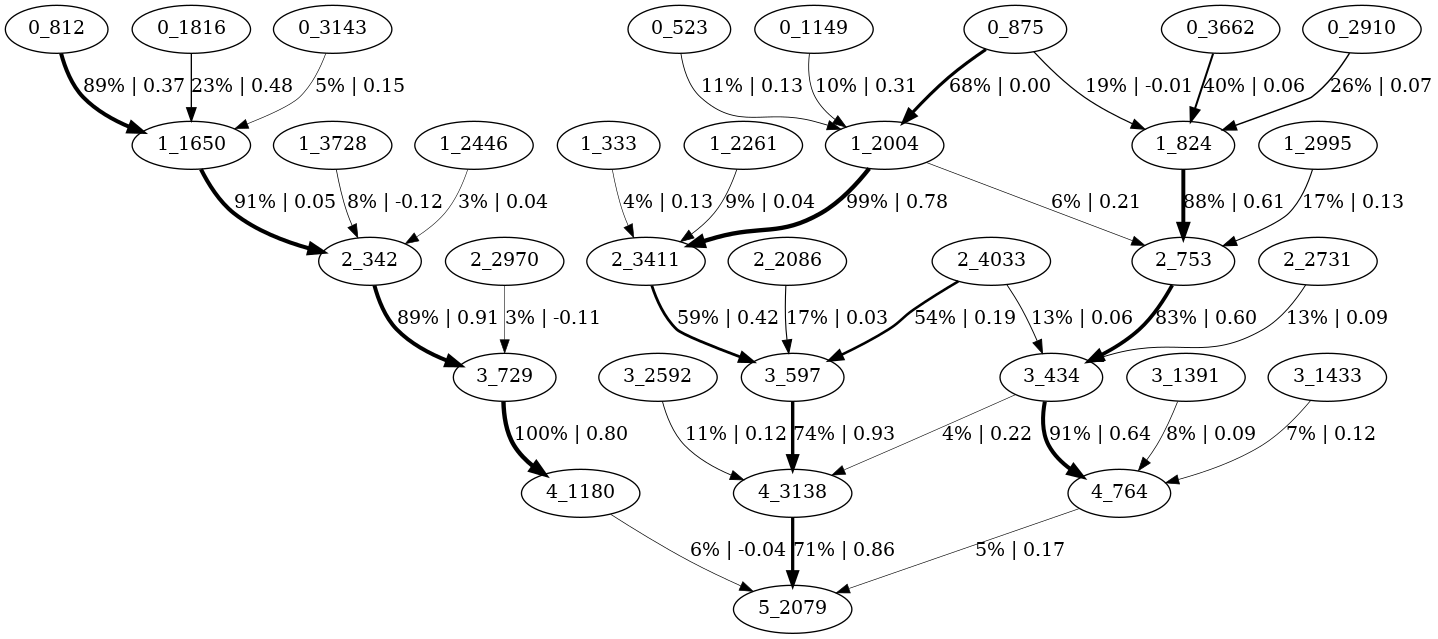

In [18]:
import pygraphviz as pgv
from IPython.display import Image
features_found_in_layers = []
target_feature = 2079
target_layer = 5
setting = "ablate"
# setting = "restore"
data_setting = "max"
# data_setting = "median_to_max"
features_found_in_layers.append([target_feature])
num_datapoints_k = 20  # Number of top (or uniform) activating examples to consider when ablating
graph_children_init_k = 3
graph_children_recurse_k= 3

# set torch seed to 0
torch.manual_seed(0)
# set np seed to 0
np.random.seed(0)

G = pgv.AGraph(directed=True)
for layer in range(target_layer, 0, -1): 
    current_features = []
    for feature in features_found_in_layers[-1]:
        activations = find_causal_features(feature, layer, k=num_datapoints_k, previous_layer=layer-1, setting=setting, data_setting=data_setting)
        if(layer == target_layer):
            values, indices = activations.topk(graph_children_init_k)
            current_features = indices.tolist()
        else:
            values, indices = activations.topk(graph_children_recurse_k)
            current_features.append(indices[0].item())
        for v, i in zip(values, indices):
            # Calculate the CS between the feature and the causal feature
            if(v < 0.01):
                continue
            v1 = dictionaries[layer][feature]
            v2 = dictionaries[layer-1][i.item()]
            cs = torch.nn.functional.cosine_similarity(v1, v2, dim=0)
            G.add_edge( f"{layer-1}_{i}", f"{layer}_{feature}", label=f"{int(v.item()*100)}% | {cs.item():.2f}", penwidth=3*v.item()+ 0.3)
            # G.add_edge( f"{layer-1}_{i}", f"{layer}_{feature}", penwidth=3*v.item()+ 0.3)
            # G.get_node(f"{layer-1}_{i}").attr['shape'] = 'box'
            # G.get_node(f"{layer-1}_{i}").attr['fillcolor'] = '#40e0d0'
            # G.get_node(f"{layer-1}_{i}").attr['style'] = 'rounded,filled'
            # G.get_node(f"{layer}_{feature}").attr['shape'] = 'box'
            # G.get_node(f"{layer}_{feature}").attr['fillcolor'] = '#40e0d0'
            # G.get_node(f"{layer}_{feature}").attr['style'] = 'rounded,filled'
    features_found_in_layers.append(list(set(current_features)))
    print(features_found_in_layers)
G.layout(prog="dot")
G.draw('file.png')  # Draws a png

# # Display the graph
Image(filename='file.png')

In [24]:
# Save Graph
# G.write('file.dot')
# Graphviz load file.dot


In [101]:
"4_1180\nOutlier Dimension"
"4_3138\nPhrases, dates, acronyms after (. Predicts )"
"4_764\nAcronyms after (. Predicts )"
"3_729\nOutlier Dimension"
"3_2592\n (, Predicts words in parantheses"
"3_597\nVarious text after (. Predicts )"
"3_434\nAcronyms after (. Predicts ) & acronyms"
"3_1391\nAcronyms. Predicts Acronyms"
"3_1433\nEnd of Acronym"
"2_342\nOutlier Dimension"
"2_2970\nOutlier Dimension
"2_3411\n( & words in parantheses, especially if first tokens in sequence"
"2_2086\n( especially after a name"
"2_4033\n( especially for acronyms"
"2_753\n( & Acronyms after (. Predicts acronyms"
"2_2731\n( especially for acronyms in paper/scientific context"
"1_1650\nOutlier Dimension"
"1_3728\nFirst\\n delimiter"
"1_2446\nFirst position in sequence"
"1_333\n("
"1_2261\n( especially w/ no preceding spaces"
"1_2004\n( in first pos in sequence"
"1_824\nAcronyms after ("
"1_2995\nAcronyms, especially after ("
"0_812\nFirst period"
"0_1816\nAny \\n"
"0_3143\nUnknown"
"0_523\nUnknown"
"0_1149\n( & first token after"
"0_875\n( especially at first position"
"0_3662\n( in general"
"0_2910\nAcronyms especially the last part"

SyntaxError: unterminated string literal (detected at line 11) (1755467203.py, line 11)

In [24]:
G = pgv.AGraph("file.dot")

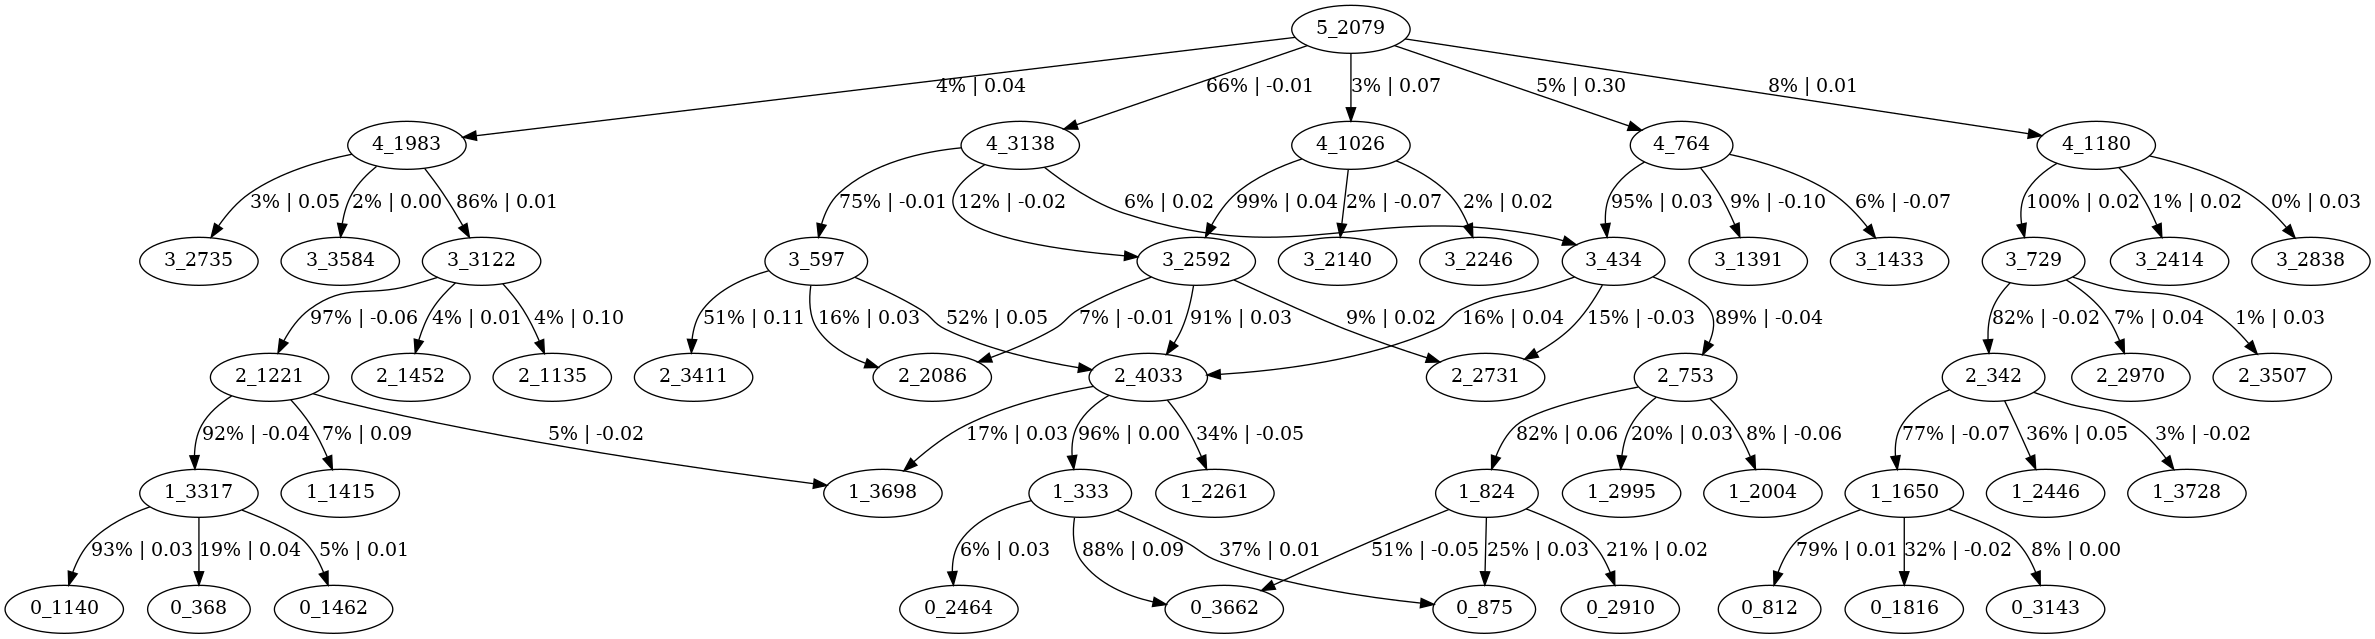

In [27]:
G.layout(prog="dot")
G.draw('file.png') 
Image(filename='file.png')

In [7]:
# G.layout(prog="dot")
# G.draw('file.png')  # Draws a png

# # # Display the graph
# Image(filename='file.png')

NameError: name 'G' is not defined

In [107]:
all_dict_activations[target_layer][:,feature].count_nonzero()

tensor(0)

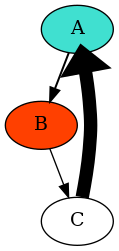

In [76]:
import pygraphviz as pgv
from IPython.display import Image  # for Jupyter notebooks

# Create a new graph
G = pgv.AGraph(strict=False, directed=True)

# Add nodes and edges
G.add_node('A', fillcolor="#40e0d0", style="filled")
G.add_node('B', fillcolor="#ff4000", style="filled")
# G.get_node('A').attr['shape'] = 'box'
G.get_node('A').attr['fillcolor'] = '#40e0d0'
G.get_node('A').attr['style'] = 'rounded,filled'
G.add_node('C')

G.add_edge('A', 'B', penwidth=1.5)
G.add_edge('B', 'C')
G.add_edge('C', 'A', penwidth=10.0)

# Layout and draw
G.layout(prog='dot')
G.draw('file.png')

# Display the graph (for Jupyter notebooks)
Image(filename='file.png')


In [148]:
# G.draw("file.png", args='-Gdpi=200', prog="dot")

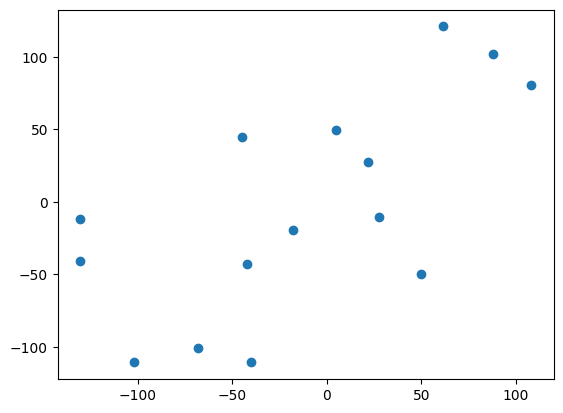

In [ ]:
# from sklearn.manifold import TSNE
# import matplotlib.pyplot as plt

# # Run the t-SNE algorithm
# tsne = TSNE(n_components=2, random_state=0, perplexity=5)
# vectors_2d = tsne.fit_transform(vectors)

# # Plot the vectors
# plt.scatter(vectors_2d[:, 0], vectors_2d[:, 1])
# plt.show()

In [102]:
GG = G

# Feature Interp
Investigate the example sentences the activate this feature.

Max: show max activating (tokens,contexts)

Uniform: Show range of activations from each bin (e.g. sample an example from 1-2, 2-3, etc). 
[Note: if a feature is monosemantic, then the full range of activations should be that feature, not just max-activating ones]

Full_text: shows the full text example

Text_list: shows up to the most activating example (try w/ max activating on a couple of examples to see)

ablate_text: remove the context one token at a time, and show the decrease/increase in activation of that feature

ablate_feature_direction: removes feature direction from model's activation mid-inference, showing the logit diff in the output for every token.

logit_lens: show the logit lens for that feature. If matches ablate_feature_direction, then the computation path is through the residual stream, else, it's through future layers

In [ ]:
# # Layer 5
# GG.get_node("5_325").attr["label"] = "5_325\nLast word in parantheses. Causes end parantheses"
# # Layer 4
# GG.get_node("4_1527").attr["label"] = "4_1527\nYears after ("
# GG.get_node("4_1456").attr["label"] = "4_1456\nMath variables after (, predicts closing )"
# GG.get_node("4_1280").attr["label"] = "4_1280\nDates, particularly years"
# # Layer 3
# GG.get_node("3_1407").attr["label"] = "3_1407\nYears, especially after ("
# GG.get_node("3_663").attr["label"] = "3_663\nYears right after (, specifically trial/court data"
# GG.get_node("3_1360").attr["label"] = "3_1360\nEnding numbers in trial/court data"
# GG.get_node("3_891").attr["label"] = "3_891\nasides/phrases"
# GG.get_node("3_1273").attr["label"] = "3_1273\nAcronyms"
# GG.get_node("3_1594").attr["label"] = "3_1594\nWords & Dates?"
# GG.layout(prog="dot")
# G.draw('file.png')  # Draws a png

# # # Display the graph
# Image(filename='file.png') #[[325], [1280, 1709, 1456, 1814, 1527], [0, 331, 1227, 210, 1407]]
# GG

In [3]:
layer = 4
layer_index = layers.index(layer)
autoencoder = autoencoders[layer_index]
# t = " I do like a"
# t = " He had a first one (1), and then a second (2"
t = "Das Berghain ist ein bekannter Nachtclub in Berlin, der für"
split_text = model.to_str_tokens(t, prepend_bos=False)
token = model.to_tokens(t, prepend_bos=False)
_, cache = model.run_with_cache(token.to(model.cfg.device))
neuron_act_batch = cache[cache_name]
act = autoencoder.encode(neuron_act_batch.squeeze())
# neg = " He had a first one (1), and then a second 2"
# split_text = model.to_str_tokens(neg, prepend_bos=False)
# token = model.to_tokens(neg, prepend_bos=False)
# _, cache = model.run_with_cache(token.to(model.cfg.device))
# neuron_act_batch = cache[cache_name]
# act[-1, :] -= smaller_auto_encoder.encode(neuron_act_batch.squeeze())[-1,:]
v, i = act[-1, :].topk(10)

print("Activations:",[round(val,2) for val in v.tolist()])
print("Feature_ids", i.tolist())

NameError: name 'layers' is not defined

In [185]:
layer = 0
layer_index = layers.index(layer)
autoencoder = autoencoders[layer_index]
autoencoder.to_device(device)
dictionary = dictionaries[layer_index]
dictionary_activations = all_dict_activations[layer_index]
select_max_indices = max_indices[layer_index]
# N = 39
# best_feature = int(select_max_indices[N])
best_feature = 2910 #[[2079], [3138, 1026, 764, 1180, 1983], [2592, 434, 3122, 597, 729], [1221, 4033, 753, 342], [824, 1650, 333, 3317], [1140, 812, 3662]]

print("bias:", autoencoder.encoder_bias.detach().cpu().numpy()[best_feature])
print(f"Feature index: {best_feature}")
print(f"MCS: {max_cosine_similarities[best_feature]}")
# text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="uniform")
text_list, full_text, token_list, full_token_list = get_feature_datapoints(best_feature, dictionary_activations, dataset, setting="max")
# visualize_text(text_list, best_feature, model, autoencoder, layer)
visualize_text(full_text, best_feature, model, autoencoder, layer)

bias: -1.9022319
Feature index: 2910
MCS: 0.15171079337596893


In [182]:
ablate_text(text_list, best_feature, model, autoencoder, layer)

In [183]:
# ablate_feature_direction_display(full_text, best_feature, layer)
ablate_feature_direction_display(full_text, autoencoder, layer, features=best_feature)

In [184]:
logit_lens(model, best_feature, dictionary, layer)

['DL', 'BP', 'KA', 'ER', 'FC', 'KS', 'KR', 'IGEN', 'AIN', 'ILY', 'AS', 'APE', 'K', 'BS', 'AG', 'AT', 'OT', 'PV', 'INS', 'BA']
tensor([1.9401, 1.9178, 1.9173, 1.9088, 1.9077, 1.8991, 1.8972, 1.8913, 1.8822,
        1.8665, 1.8665, 1.8236, 1.8166, 1.8106, 1.8068, 1.7991, 1.7983, 1.7960,
        1.7936, 1.7877])


In [146]:
custom_text = [
    "(",
    " And this one doesn't (",
    " And this one doesn't(",
    " And this one doesn't PPPP(",
]
visualize_text(custom_text, best_feature, model, autoencoder, layer)

In [39]:
# Given a feature direction in layer 4, multiply by the layer norm2, and then multiply by the MLP? I need to be careful about running it through the entire MLP

layer = 3
feature = 1273
feature_direction = rearrange(dictionaries[layer-1][feature], 'h -> 1 1 h').to(device)
with torch.no_grad():
    # # MLP
    # feature_direction = model.blocks[layer].ln2(feature_direction)
    # translated_feature_direction = rearrange(model.blocks[layer].mlp(feature_direction), '1 1 h -> h')
    # Attention
    # feature_direction = model.blocks[layer].ln1(feature_direction)
    # TODO: check if position_ids make sense
    translated_feature_direction = model_transformers.gpt_neox.layers[layer].attention(feature_direction, attention_mask=None, position_ids=torch.tensor([[0]]).to(device))[0]

NameError: name 'model_transformers' is not defined

In [ ]:
# Now do cosine similarity between the translated feature and future layer
future_layer_dictionary = dictionaries[layer].to(device)
cs = torch.nn.functional.cosine_similarity(translated_feature_direction, future_layer_dictionary, dim=1)
print(f"ind = {cs.topk(10).indices.cpu().tolist()[0]}\nind = {cs.topk(10, largest=False).indices.cpu().tolist()[0]}")

ind = [111, 25, 78, 386, 23, 73, 107, 104, 384, 232]
ind = [376, 418, 216, 271, 17, 37, 498, 510, 320, 417]


In [134]:
# download pythia-70m from transformer library
from transformers import AutoTokenizer, AutoModelForCausalLM
model_transformers = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [99]:
# Convert torch tensor to list
def tensor_to_list(tensor):
    

(torch.return_types.topk(
 values=tensor([0.2552, 0.1810, 0.1621, 0.1565, 0.1476, 0.1366, 0.1291, 0.1277, 0.1267,
         0.1239], device='cuda:3', grad_fn=<TopkBackward0>),
 indices=tensor([ 884, 1191, 1688, 1490,   50,  269, 1982,  117, 1579,  602],
        device='cuda:3')),
 torch.return_types.topk(
 values=tensor([-0.2278, -0.1981, -0.1899, -0.1629, -0.1499, -0.1454, -0.1450, -0.1399,
         -0.1388, -0.1383], device='cuda:3', grad_fn=<TopkBackward0>),
 indices=tensor([1352,  796, 1100, 1273,  921, 1868,  342, 1052,  384, 1219],
        device='cuda:3')))

In [ ]:
t = " I do like a"
split_text = model.to_str_tokens(t, prepend_bos=False)
token = model.to_tokens(t, prepend_bos=False)
_, cache = model.run_with_cache(token.to(model.cfg.device))
neuron_act_batch = cache[cache_name]
_, act = smaller_auto_encoder(neuron_act_batch)
v, i = act[0, -1, :].topk(10)

print("Activations:",[round(val,2) for val in v.tolist()])
print("Feature_ids", i.tolist())

NameError: name 'smaller_auto_encoder' is not defined

In [ ]:
sentence = " for"
temp = 0.7
tokens_to_generate = 20
feature = 10 
scalar = 100.0
# Using the function:
print("Normal:\n" + generate_text(sentence, tokens_to_generate, model, smaller_auto_encoder, feature=feature, temperature=temp, scalar=scalar, setting="normal"))
print("Add:\n" + generate_text(sentence, tokens_to_generate, model, smaller_auto_encoder, feature=feature, temperature=temp, scalar=scalar, setting="add"))

NameError: name 'smaller_auto_encoder' is not defined

In [ ]:
smaller_dict[best_feature].topk(10), smaller_dict[best_feature].topk(10, largest=False)

(torch.return_types.topk(
 values=tensor([0.0197, 0.0193, 0.0117, 0.0088, 0.0077, 0.0074, 0.0065, 0.0064, 0.0061,
         0.0060]),
 indices=tensor([1299,  412,  481,  305, 1887, 1564, 1643,  319,  768, 1488])),
 torch.return_types.topk(
 values=tensor([-0.8940, -0.4320, -0.0470, -0.0292, -0.0127, -0.0119, -0.0102, -0.0081,
         -0.0070, -0.0070]),
 indices=tensor([ 568,  516, 1894,  468, 1326, 1458,  615,  934,  870, 1518])))

In [ ]:
# OUTlier dimensions negative:
#  568,  516, 1894,  468, 1299, 1326,  412, 1458,  934,  615, 1147,  672, 1377, 1518, 1889,  715, 1325,
# outlier dims positive:
# 412,  481,  305, 1894,  319, 1887, 1643, 1876,  801,  615,  362, 1564, 1323,   25,  989, 

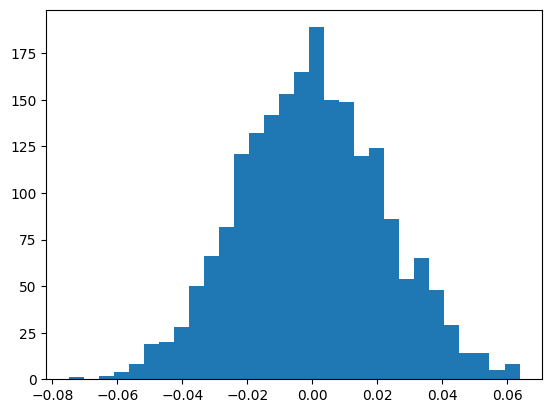

In [ ]:
# Check features non-zero weights in decoder
# Plot a histogram of the weights
weights = smaller_dict[best_feature]
plt.hist(weights, bins=30)
plt.show()

In [ ]:
weights.topk(10, largest=False)

torch.return_types.topk(
values=tensor([-0.8940, -0.4320, -0.0470, -0.0292, -0.0127, -0.0119, -0.0102, -0.0081,
        -0.0070, -0.0070]),
indices=tensor([ 568,  516, 1894,  468, 1326, 1458,  615,  934,  870, 1518]))

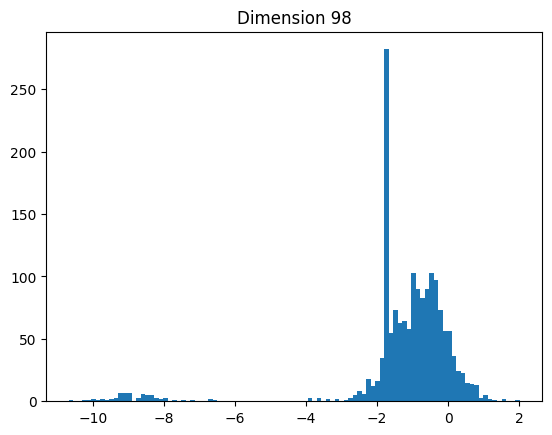

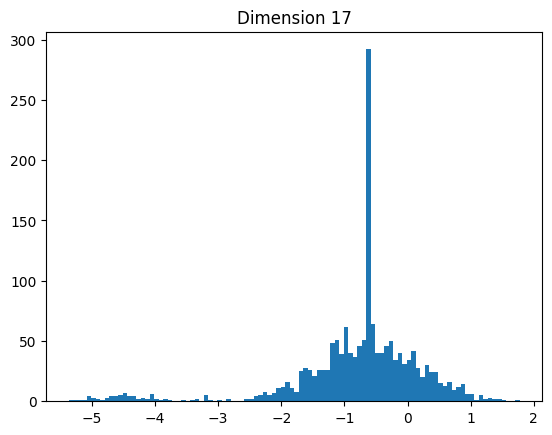

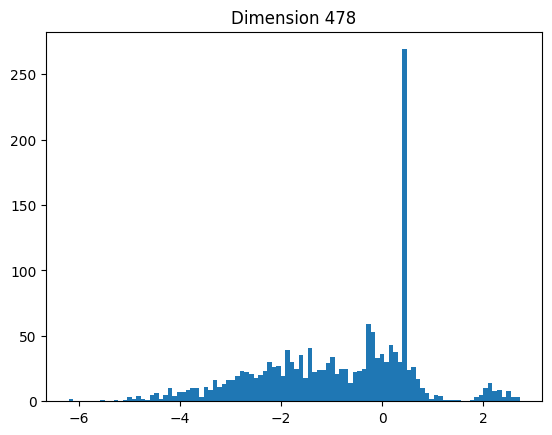

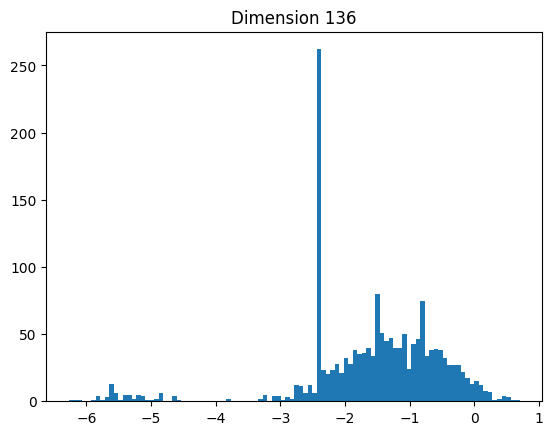

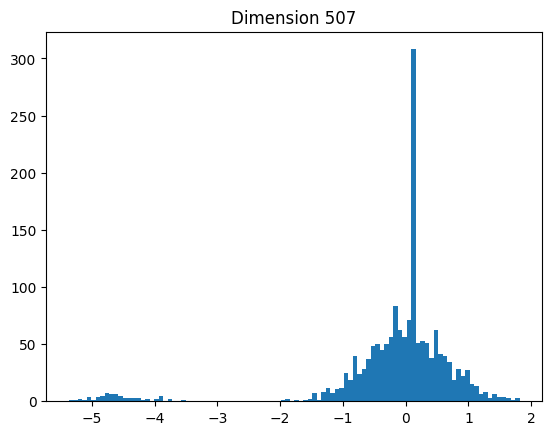

In [ ]:
# Replicate activation of position
# plot as hist
import matplotlib.pyplot as plt
for i in range(5):
    # make new fig
    plt.figure()
    act = neuron_activations[3:100000:token_amount, outlier_dimension.indices[i]]
    plt.title(f"Dimension {outlier_dimension.indices[i]}")
    plt.hist(act, bins=100)
# plt.show()

In [35]:
import numpy as np
from collections import Counter
# For the outlier values that aren't first position, what are the tokens?
# Find index of outlier values that aren't first position
for di in all_dict_activations:
    outlier_dimensions = di.max(dim=0).values.topk(10)
    for i in range(5):
        outlier_indices = torch.where(di[:10000, outlier_dimensions.indices[i]] > 0)[0]
        # Only do first indice now
        outlier_indices = outlier_indices[outlier_indices % token_amount != 0]
        # Find the tokens associated w/ them
        indices = [np.unravel_index(oi, (datapoints, token_amount)) for oi in outlier_indices]
        token_list = []    
        for md, s_ind in indices:
            md = int(md)
            s_ind = int(s_ind)
            tok = dataset[md]["input_ids"][s_ind]
            token_list.append(model.tokenizer.decode(tok))
        token_list
        # Count the unique occurrences of the tokens
        Counter(token_list)
        print(f"{i} {Counter(token_list)}")

0 Counter({'\n': 541, '.': 161, ' the': 140, ',': 96, ' a': 84, ':': 78, ' is': 61, ' and': 55, ' of': 45, ' in': 41, 'I': 30, 'The': 28, ' (': 24, ' I': 20, ' was': 19, '?': 19, ' with': 19, ' have': 17, ' for': 17, ' to': 16, ' on': 15, '’': 14, ' this': 12, ' your': 11, ' are': 11, ' an': 10, ' The': 10, 's': 10, ' relates': 10, ' has': 9, "'s": 9, ' my': 9, ' it': 9, 'This': 9, ' invention': 9, 'In': 8, "'m": 8, ' that': 8, ' by': 7, '-': 7, ' new': 6, ' "': 6, ' our': 6, ' P': 6, ' present': 6, 'Is': 6, ' we': 5, ' file': 5, 'To': 5, ' am': 5, ' article': 5, ' using': 5, ')': 5, ' 2': 5, ' K': 5, 'A': 5, 'ia': 5, ' C': 5, ' create': 5, 'ers': 5, " '": 5, ' S': 4, ' were': 4, ' you': 4, ' term': 4, ' R': 4, ' currently': 4, '...': 4, '!': 4, ' analysis': 4, ' study': 4, "'ve": 4, ' –': 4, ' between': 4, ' -': 4, ' Field': 4, ' Invention': 4, 'How': 4, ' its': 4, ' American': 4, ' D': 4, '<': 4, 'We': 4, 'abstract': 4, '].': 4, ' group': 4, ' F': 3, ' M': 3, ' show': 3, ' can': 3, '

In [33]:
for di in all_dict_activations:
    outlier_dimensions = di.max(dim=0).values.topk(10).indices
    print(outlier_dimensions)

torch.return_types.topk(
values=tensor([31.6288, 13.1711,  7.4994,  7.2150,  7.0181,  6.8310,  6.7971,  6.7736,
         6.7303,  6.6494]),
indices=tensor([1717, 1998, 1314, 1830,  639,  924, 1819, 1602,  923, 1679]))
torch.return_types.topk(
values=tensor([183.5879, 121.1568,  33.1601,  11.9241,   9.3592,   8.1727,   7.2512,
          7.0427,   6.8385,   6.8361]),
indices=tensor([1891,  389, 1958, 1178,  232, 1901, 1896,  206,  200,  989]))
torch.return_types.topk(
values=tensor([220.3352,  28.3979,  22.7274,  18.1072,  16.6322,  15.7106,  14.5732,
         12.1935,   9.4991,   9.3403]),
indices=tensor([1178, 1589,  559, 1417,  902,  766,  882,  588, 1827, 1283]))
torch.return_types.topk(
values=tensor([150.1703,  32.9617,  25.2257,  14.3390,  13.8567,  13.5557,  12.9401,
         12.1904,  11.5138,  11.3889]),
indices=tensor([1891, 1127, 1589, 1391, 1958,  412,  683,  588,  315, 1760]))
torch.return_types.topk(
values=tensor([103.6790,  37.0541,  34.0877,  33.9247,  32.4672,  29.9099

AttributeError: 'list' object has no attribute 'shape'

In [13]:
all_dict_activations[0].shape

torch.Size([118800, 2048])

In [ ]:
dictionary_activations[:, best_feature].count_nonzero().sum() / dictionary_activations.shape[0], dictionary_activations[:, best_feature].count_nonzero(dim=0)

(tensor(0.0654), tensor(37947))

In [ ]:
nz = dictionary_activations.count_nonzero(dim=0)

In [ ]:
nz.median() / dictionary_activations.shape[0]

tensor(0.0008)

In [ ]:
custom_text = [
    "I can count up to: 2 4 8 16 32 64 128 256 512 1024 2048 4096 8192 16384 32768 7 6 12 16 18 20 22 24",
]
visualize_text(custom_text, best_feature, model)

# Data Centric Viewpoint

In [ ]:
# Go through datapoints & see if the features that activate on them make sense.
d_point = 0
# text = tokens_dataset[d_point]
data_ind, sequence_pos = np.unravel_index(d_point, (datapoints, token_amount))
feature_val, feature_ind = dictionary_activations[d_point].topk(10)
data_ind = int(data_ind)
sequence_pos = int(sequence_pos)
full_tok = torch.tensor(dataset[data_ind]["input_ids"])
full_text = []
full_text.append(model.tokenizer.decode(full_tok))
visualize_text(full_text, feature_ind, model)

# Check the neuron/residual basis
When we look at the weights of a feature, we are seeing the literal dimensions from the residual stream/neurons being read from the feature. 

Here I'm visualizing the weight values for the residual stream. If there are outliers, then it's mainly reading from that dimension.

In [ ]:
(weights*max_activation).topk(20), (weights*max_activation).topk(20, largest=False).values, (weights*max_activation > 0.2).sum()

(torch.return_types.topk(
 values=tensor([0.6161, 0.6114, 0.6067, 0.5887, 0.5883, 0.5792, 0.5636, 0.5437, 0.5429,
         0.5255, 0.5244, 0.5211, 0.5182, 0.5153, 0.4998, 0.4976, 0.4894, 0.4885,
         0.4840, 0.4824]),
 indices=tensor([ 371,  481,   42, 1080,  725, 1381, 1745, 1926,  604,  307,  568,   22,
         1508, 1670, 1998,  679, 1081, 1115,  122, 1876])),
 tensor([-0.6566, -0.6534, -0.6292, -0.6198, -0.6115, -0.5850, -0.5844, -0.5834,
         -0.5819, -0.5580, -0.5519, -0.5455, -0.5435, -0.5435, -0.5406, -0.5404,
         -0.5395, -0.5389, -0.5320, -0.5313]),
 tensor(332))

# Prepend/Append tokens
We can iterate over all tokens to check which ones activate a feature a lot to more rigorously test a hypothesis on what a feature means.

Note: I'm literately running the model through all 50k tokens prepended to the text here

In [ ]:
def prepend_all_tokens_and_get_feature_activation(model, minimal_activating_example, feature, setting="prepend"):
    tokens = model.to_tokens(minimal_activating_example, prepend_bos=False)

    # Run through every number up to vocab size
    vocab_size = model.cfg.d_vocab
    batch_size = 256*2 # Define your desired batch size

    dollar_feature_activations = torch.zeros(vocab_size)
    for start in range(0, vocab_size, batch_size):
        end = min(start + batch_size, vocab_size)

        token_prep = torch.arange(start, end).to(device)
        token_prep = token_prep.unsqueeze(1)  # Add a dimension for concatenation

        # 1. Prepend to the tokens
        if setting == "prepend":
            tokens_catted = torch.cat((token_prep, tokens.repeat(end - start, 1)), dim=1).long()
        elif setting == "append":
            tokens_catted = torch.cat((tokens.repeat(end - start, 1), token_prep), dim=1).long()
        else:
            raise ValueError(f"Unknown setting: {setting}")

        # 2. Run through the model
        with torch.no_grad():
            _, cache = model.run_with_cache(tokens_catted.to(device))
            neuron_act_batch = cache[cache_name]
            _, act = smaller_auto_encoder(neuron_act_batch)

        # 3. Get the feature
        dollar_feature_activations[start:end] = act[:, -1, feature].cpu().squeeze()

    k = 20
    k_increasing_val, k_increasing_ind = dollar_feature_activations.topk(k)
    k_decreasing_val, k_decreasing_ind = dollar_feature_activations.topk(k, largest=False)
    if(setting == "prepend"):
        print(f"[token]{minimal_activating_example}")
    elif(setting == "append"):
        print(f"{minimal_activating_example}[token]")
    else:
        raise ValueError(f"Unknown setting: {setting}")
    # Print indices converted to tokens
    print(f"Top-{k} increasing: {model.to_str_tokens(k_increasing_ind)}")
    # Print values
    print(f"Top-{k} increasing: {[f'{val:.2f}' for val in k_increasing_val]}")
    print(f"Top-{k} decreasing: {model.to_str_tokens(k_decreasing_ind)}")
    print(f"Top-{k} decreasing: {[f'{val:.2f}' for val in k_decreasing_val]}")
    print(f"Number of 0 activations: {torch.sum(dollar_feature_activations == 0)}")
    if(setting == "prepend"):
        best_text = "".join(model.to_str_tokens(dollar_feature_activations.argmax()) + [minimal_activating_example])
    else:
        best_text = "".join([minimal_activating_example] + model.to_str_tokens(dollar_feature_activations.argmax()))
    return best_text

best_text = ""
for x in range(3):
    # best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="prepend")
    best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="append")
# prepend_all_tokens_and_get_feature_activation(model, " for all $", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="append")

[token]
Top-20 increasing: ['1', ')', '#', '/', '+', "'", '2', '<|padding|>', '*', '$', '.', ',', '&', '0', '"', '(', '<|endoftext|>', '!', '%', '-']
Top-20 increasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Top-20 decreasing: ['1', ')', '#', '/', '+', "'", '2', '<|padding|>', '*', '$', '.', ',', '&', '0', '"', '(', '<|endoftext|>', '!', '%', '-']
Top-20 decreasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Number of 0 activations: 50304
<|endoftext|>[token]
Top-20 increasing: [' motivated', ' daring', ' strained', ' accommodating', ' foregoing', 'erred', ' hopes', 'ought', 'ough', 'uding', ' threatened', ' wanting', 'owing', ' appreciated', ' interested', ' limited', ' wonders', ' nominated', ' welcoming', ' able']
Top-20 increasing: ['5.63', '5.54

In [ ]:
best_text = ""
for x in range(3):
    best_text = prepend_all_tokens_and_get_feature_activation(model, best_text, best_feature, setting="prepend")

[token]
Top-20 increasing: ['1', ')', '#', '/', '+', "'", '2', '<|padding|>', '*', '$', '.', ',', '&', '0', '"', '(', '<|endoftext|>', '!', '%', '-']
Top-20 increasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Top-20 decreasing: ['1', ')', '#', '/', '+', "'", '2', '<|padding|>', '*', '$', '.', ',', '&', '0', '"', '(', '<|endoftext|>', '!', '%', '-']
Top-20 decreasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Number of 0 activations: 50304
[token]<|endoftext|>
Top-20 increasing: [' hereto', ' preempt', ' decis', ' investigated', ' across', ' impacting', ' transfected', ' issuing', ' advocated', ' cheaper', ' funded', ' harboring', ' poorer', ' deploying', ' neurolog', ' enrolled', ' corroborated', ' exerted', ' desir', ' promoted']
Top-20 increasing: 

In [ ]:
prepend_all_tokens_and_get_feature_activation(model, " for all $", best_feature, setting="prepend")
# prepend_all_tokens_and_get_feature_activation(model, "The", best_feature, setting="append")
# prepend_all_tokens_and_get_feature_activation(model, " tree", best_feature, setting="append")

[token] for all $
Top-20 increasing: [' transgender', 'Love', ' gay', ' LGBT', ' homosexuality', ' feminist', ' activists', ' feminism', ' linebacker', ' activism', ' homosexual', ' abortion', ' Europese', 'Women', ' lesbian', ' racial', ' Latino', ' undercover', ' Citizens', ' legendary']
Top-20 increasing: ['2.68', '2.65', '2.56', '2.50', '2.49', '2.46', '2.35', '2.34', '2.34', '2.33', '2.33', '2.29', '2.27', '2.26', '2.26', '2.14', '2.07', '2.04', '2.02', '1.99']
Top-20 decreasing: ['1', ')', '#', '/', '+', "'", '2', '<|padding|>', '*', '$', '.', ',', '&', '0', '"', '(', '<|endoftext|>', '!', '%', '-']
Top-20 decreasing: ['0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00', '0.00']
Number of 0 activations: 48712


' transgender for all $'